In [3]:
# todo: comment this file

Num GPUs Available: 0
Loaded keys: ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'scaler', 'scaler_y', 'test_dates']
X_train: (997079, 21) y_train: (997079,)
X_val:   (213660, 21) y_val:   (213660,)
X_test:  (213661, 21) y_test:  (213661,)
X_train_seq: (997074, 5, 21) y_train_seq: (997074,)
X_val_seq:   (213655, 5, 21) y_val_seq:   (213655,)
X_test_seq:  (213656, 5, 21) y_test_seq:  (213656,)
Epoch 1/2
31158/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0248Epoch 001 - Train RMSE (stored scale): 0.1908
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 549s 18ms/step - loss: 0.0220 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 2/2
31158/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192Epoch 002 - Train RMSE (stored scale): 0.1889
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 357s 11ms/step - loss: 0.0186 - val_loss: 0.0376 - learning_rate: 0.0010


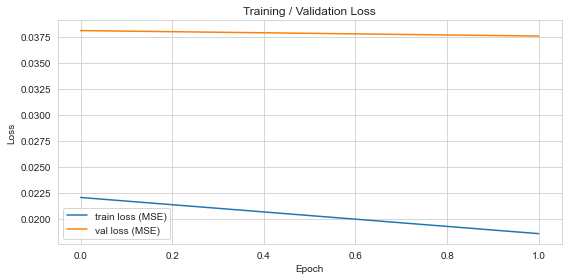

Test RMSE (stored scale): 0.1901
Test RMSE (original units): 0.9051


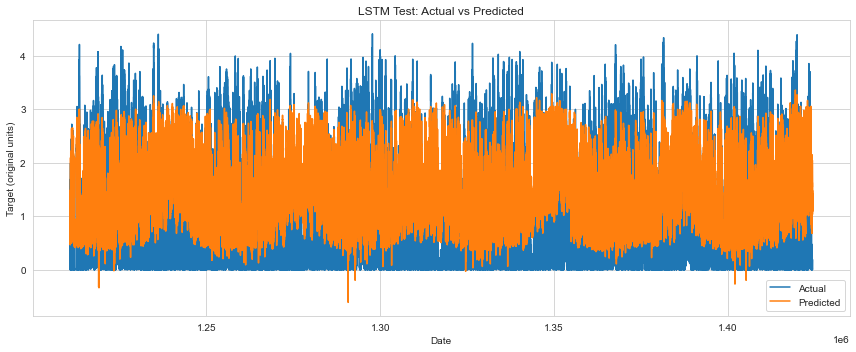

In [4]:
# -*- coding: utf-8 -*-
"""
LSTM baseline (fixed):
- Prevents pandas label-indexing bugs by converting y to NumPy before sequencing
- Uses float32 for TF stability/performance
- Reports RMSE on the same scale as FFN/WaveNet (no forced inverse_transform)
- Optionally also reports/plots in original units if y_scaler is present AND y looks scaled
"""

import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback


# -----------------------
# Config
# -----------------------
SEED = 42
SEQUENCE_LENGTH = 5
EPOCHS = 2 #use 20 instead of 2
BATCH_SIZE = 32

PLOT_LOSS = True
PLOT_TEST_PREDICTIONS = True

# If you want strictly the same metric style as FFN/WaveNet, keep this True
REPORT_RMSE_ON_STORED_SCALE = True

# Optional: also report/plot in original units if we can safely inverse-transform
REPORT_AND_PLOT_ORIGINAL_UNITS_IF_POSSIBLE = True


# -----------------------
# Reproducibility
# -----------------------
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

print("Num GPUs Available:", len(tf.config.list_physical_devices("GPU")))


# -----------------------
# Helpers
# -----------------------
def to_numpy_float32(x):
    """Convert pandas/np to numpy float32."""
    if hasattr(x, "to_numpy"):
        return x.to_numpy(dtype=np.float32)
    if hasattr(x, "values"):
        return np.asarray(x.values, dtype=np.float32)
    return np.asarray(x, dtype=np.float32)

def to_1d_float32(y):
    """Convert to 1D numpy float32."""
    y = np.asarray(y, dtype=np.float32)
    return y.reshape(-1)

def create_sequences(X, y, seq_length):
    """
    X: (n, features)
    y: (n,)
    returns:
      X_seq: (n-seq_length, seq_length, features)
      y_seq: (n-seq_length,)
    """
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32).reshape(-1)

    if len(X) != len(y):
        raise ValueError(f"X and y length mismatch: len(X)={len(X)} vs len(y)={len(y)}")
    if len(X) <= seq_length:
        raise ValueError(f"Not enough rows to build sequences: len(X)={len(X)} <= seq_length={seq_length}")

    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i : i + seq_length])
        y_seq.append(y[i + seq_length])

    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

def looks_like_minmax_scaled(y, scaler, tol=1e-3):
    """
    Conservative heuristic: if scaler has feature_range and y lies inside it -> likely scaled.
    """
    if scaler is None or not hasattr(scaler, "feature_range"):
        return False
    lo, hi = scaler.feature_range
    y_min, y_max = float(np.min(y)), float(np.max(y))
    return (y_min >= lo - tol) and (y_max <= hi + tol)

def safe_inverse_transform_1d(y_1d, scaler):
    """
    Inverse-transform a 1D array safely if scaler supports it.
    """
    y_1d = np.asarray(y_1d, dtype=np.float32).reshape(-1, 1)
    return scaler.inverse_transform(y_1d).reshape(-1)

class TrainRMSECallback(Callback):
    """
    Prints train RMSE (on stored scale) at epoch end.
    Note: uses predict() each epoch, can be slow on large datasets.
    """
    def __init__(self, X_train_seq, y_train_seq):
        super().__init__()
        self.X = X_train_seq
        self.y = y_train_seq

    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(self.X, verbose=0).reshape(-1)
        rmse = np.sqrt(mean_squared_error(self.y, pred))
        print(f"Epoch {epoch+1:03d} - Train RMSE (stored scale): {rmse:.4f}")


# -----------------------
# Load data
# -----------------------
with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

# Convert X to numpy float32
X_train = to_numpy_float32(data["X_train"])
X_val   = to_numpy_float32(data["X_val"])
X_test  = to_numpy_float32(data["X_test"])

# Convert y to 1D numpy float32 (FIXES pandas indexing bug)
y_train = to_1d_float32(data["y_train"])
y_val   = to_1d_float32(data["y_val"])
y_test  = to_1d_float32(data["y_test"])

# Optional dates
test_dates = data.get("test_dates", None)
if test_dates is not None:
    # keep as array-like for plotting
    test_dates = np.asarray(test_dates)

# Optional scaler for y
y_scaler = data.get("scaler_y", None)

print("Loaded keys:", list(data.keys()))
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

# -----------------------
# Build sequences
# -----------------------
X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQUENCE_LENGTH)
X_val_seq,   y_val_seq   = create_sequences(X_val,   y_val,   SEQUENCE_LENGTH)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test,  SEQUENCE_LENGTH)

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_val_seq:  ", X_val_seq.shape,   "y_val_seq:  ", y_val_seq.shape)
print("X_test_seq: ", X_test_seq.shape,  "y_test_seq: ", y_test_seq.shape)

# -----------------------
# Model
# -----------------------
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X_train_seq.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
)

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    TrainRMSECallback(X_train_seq, y_train_seq),
]

# -----------------------
# Train
# -----------------------
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,   # good for time series
    callbacks=callbacks,
    verbose=1,
)

# Plot loss
if PLOT_LOSS:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history["loss"], label="train loss (MSE)")
    plt.plot(history.history["val_loss"], label="val loss (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training / Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------
# Evaluate
# -----------------------
pred_scaled = model.predict(X_test_seq, verbose=0).reshape(-1)

# RMSE on stored scale (matches FFN/WaveNet scripts)
rmse_stored = np.sqrt(mean_squared_error(y_test_seq.reshape(-1), pred_scaled))
print(f"Test RMSE (stored scale): {rmse_stored:.4f}")

# Optional: also compute RMSE in original units if we can safely inverse-transform
rmse_original = None
actual_for_plot = y_test_seq
pred_for_plot = pred_scaled
y_axis_label = "Target (stored scale)"

if (
    REPORT_AND_PLOT_ORIGINAL_UNITS_IF_POSSIBLE
    and y_scaler is not None
    and hasattr(y_scaler, "inverse_transform")
    and looks_like_minmax_scaled(y_test_seq, y_scaler)
):
    actual_orig = safe_inverse_transform_1d(y_test_seq, y_scaler)
    pred_orig   = safe_inverse_transform_1d(pred_scaled, y_scaler)
    rmse_original = np.sqrt(mean_squared_error(actual_orig, pred_orig))
    print(f"Test RMSE (original units): {rmse_original:.4f}")

    actual_for_plot = actual_orig
    pred_for_plot = pred_orig
    y_axis_label = "Target (original units)"
else:
    if REPORT_AND_PLOT_ORIGINAL_UNITS_IF_POSSIBLE and y_scaler is not None:
        print("Note: y_scaler exists, but y does not look like MinMax-scaled data -> skipping inverse_transform to avoid wrong numbers.")

# -----------------------
# Plot predictions
# -----------------------
if PLOT_TEST_PREDICTIONS:
    plt.figure(figsize=(12, 5))

    if test_dates is not None and len(test_dates) >= (SEQUENCE_LENGTH + len(actual_for_plot)):
        x = test_dates[SEQUENCE_LENGTH : SEQUENCE_LENGTH + len(actual_for_plot)]
        plt.plot(x, actual_for_plot, label="Actual")
        plt.plot(x, pred_for_plot, label="Predicted")
        plt.xlabel("Date")
    else:
        plt.plot(actual_for_plot, label="Actual")
        plt.plot(pred_for_plot, label="Predicted")
        plt.xlabel("Time step")

    plt.ylabel(y_axis_label)
    plt.title("LSTM Test: Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()